# Exercise 1

As discussed in Section 1, resizing and rescaling digital images are not trivial operations. There are many ways to resize an image, and one of them is Seam Carving.

The advantage of this method is the content awareness, which enables resizing images while preserving their visual and semantic features.

In this exercise you will:
1. Apply image processing operations as preliminares for later
2. Implement Seam Carving using a greedy algorithm
3. Implement Seam Carving as taught in lecture with dynamic programming ([original Seam Carving paper](https://faculty.runi.ac.il/arik/scweb/imret/imret.pdf))
4. Compare the methods in addition to bilinear scaling (no need to implement)


Instructions:
* The notebook is just for displaying your implementation, **do not change code in it**. Changing it might cause failure of our grading unit tests. If you want to change minor things, make sure the original one still runs and display results.
* In `utils.py` we created a template to `SeamImage`,`GreedySeamImage` and `DPSeamImage` which are classes which you will be implementing. Note that if a function does not raise a `NotImplemented` exception, it is not mandatory to implement, it is just a suggestion.
* `SeamImage` class is the parent class of the second two. It implements the common functionalities both methods share (the class attributes may help you to manage the metadata of the algorithms).
* `SeamImage` takes an image path and:
    - Loads an RGB image of the original shape
    - Creates a weighted grayscale image and stores it
    - Defines and stores all the required metadata for the Seam Carving algorithm
    - Track removed seam and later be able to visualize them

* `GreedySeamImage` inherits from `SeamImage`. Its purpose is to:
    - Apply Vertical Seam Carving algorithm using a greedy approach

* `DPSeamImage` inherits from `SeamImage`. Its purpose is to:
    - Precompute all of the needed decisions and costs using matrices
    - Apply Vertical Seam Carving algorithm using the precomputed matrices

* Both methods should use the **forward-looking** cost for their decision making.
* To get full credit, **you are expected to implement the following as efficient as possible**, and get similar runtime as we report below
* **Tip**: To apply changes from outsides modules into `ipynb` files, restarting the notebook is required when using JIT (will be introduced later). To prevent this, we recommend that you copy here the code and later test it from outside
* When submitting, the notebook must run end to end without any exception raised
* **IMPORTANT**: Submission format: **ex01_{submitter first name}\_{submitter last name}\_{submitter ID}\_{partner first name}\_{partner last name}\_{partner ID}.zip** containing `Seam Carving Assignment.ipynb` (all cells executed from start to end), the *images* folder and your implemented `utils.py`. Please stick to this exact format! Nore that the name must match the **exact names as on your Moodle**.
* Feel free to ask questions on Piazza. We also highly encourage you to answer questions (but not share code!).


#### After you complete this assignment, you will have a tool to edit any photo you wish.<br>Replace the `img_path` variable, load a photo, edit and upload to your Insta story! 
 ---

Please run the following (install libs if needed) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from PIL import Image
from numba import jit
from utils import *

%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (10,5)


In [2]:
img_path = "images/koala.jpg"

# helper functions
def read_image(img_path):
    return np.asarray(Image.open(img_path).convert('RGB')).astype('float16')


def show_image(np_img, grayscale=False):
    fig, ax = plt.subplots()
    if not grayscale:
        ax.imshow(np_img, aspect='equal')
    else:
        ax.imshow(np_img, cmap=plt.get_cmap('gray'))
    ax.axis("off")
    plt.show()


def init_plt_grid(nrow=1, ncols=1, figsize=(20,10), **kwargs):
    fig, ax = plt.subplots(nrow, ncols, figsize=figsize, facecolor='gray', **kwargs)
    font_size = dict(size=20)
    return ax, font_size

# run this

def plot_grid(sc_obj):
    ax, font_size = init_plt_grid(ncols=3, figsize=(15,10))

    orig_size = sc_obj.rgb.shape[:2]
    v_pad = (orig_size[0] - sc_obj.h) // 2
    h_pad = (orig_size[1] - sc_obj.w) // 2

    padding_width = ((v_pad, v_pad), (h_pad, h_pad), (0, 0))  # This adds 5 rows/columns of zeros on each side of the image
    padded_img = np.pad(sc_obj.resized_rgb, padding_width, mode='constant', constant_values=0)

    ax[0].set_title('Original Image', **font_size)
    ax[1].set_title('Seam Visualization', **font_size)
    ax[2].set_title('Resized Image', **font_size)

    ax[0].imshow(sc_obj.rgb)
    ax[1].imshow(sc_obj.seams_rgb)
    ax[2].imshow(padded_img)

    # save resized version
    Image.fromarray((sc_obj.resized_rgb*255).astype('uint8')).save('./resized_rgb.jpg')

    for sp in ax.reshape(-1):
        sp.set_xticks([])
        sp.set_yticks([])
    plt.tight_layout()



* * *

### 1. Implement basics of SeamImage (20 points)

Before starting, you need to have the basics done.

In this section, implement the following functions in the `SeamImage` class:

1. `SeamImage.rgb_to_grayscale`
2. `SeamImage.calc_gradient_magnitude`
   

In [3]:
# TODO: Create a SeamImage instance
s_img = SeamImage(img_path)

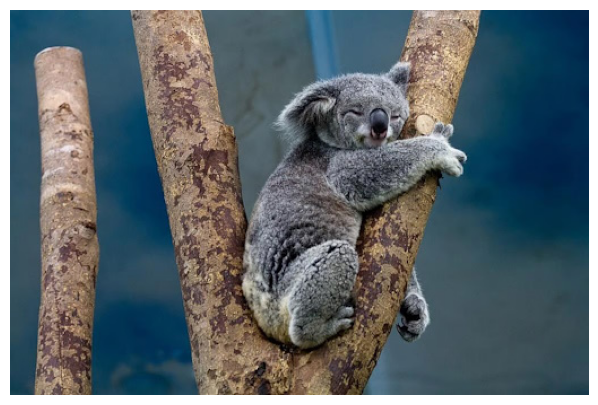

In [4]:
# display sample image we will be working on
show_image(s_img.rgb)


In this excercise we are going to manipulate this image of a koala.

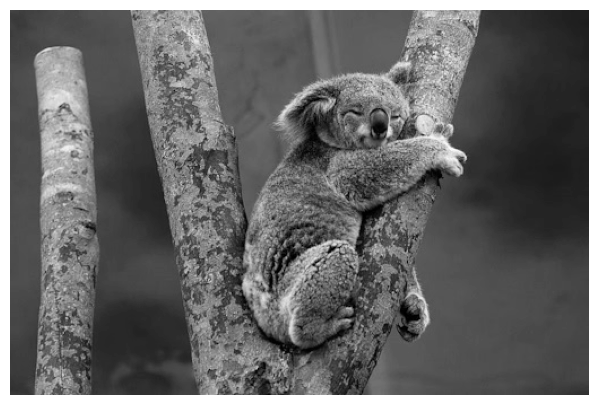

In [5]:
# disply grayscale version
show_image(s_img.gs, grayscale=True)

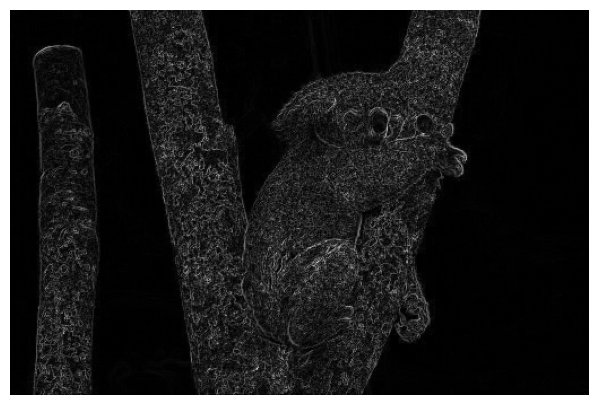

In [6]:
# display its energy (gradient magnitude)
show_image(s_img.E, grayscale=True)

### TODO: Implement the GreedySeamImage class (50 points)

GreedySeamImage stores an image, and applies vertical Seam Carving. \
This also stores meta data such as: grayscale version, gradient magnitude map, boolean masks indicating if a seam is removed or not, resized versions etc.
This class also should support horizontal seam carving by rotating the image, running vertical seam carving, and counter-rotating the image back.


Guidelines:
* Understand the flow in `SeamImage.seams_removal`
* Implement `GreedySeamImage.find_minimal_seam()` to return the minimal energy seam.
    * This must be implemented in the *subclass*, not in `SeamImage`, as you will be writing another implementation later.
    * The greedy algorithm needs to go row by row and choose the next pixel of the seam on a row-by-row basis.
    * Your implementation should not store any additional data aside from what is already stored in the template.
* Implement `SeamImage.remove_seam()` which removes a given seam from `GreedySeamImage.find_minimal_seam()`.
    * Make sure to also update the visualization with the seam you are removing.
* Implement `SeamImage.rotate_mats()`, `SeamImage.seam_removal_vertical()` and `SeamImage.seam_removal_horizontal()`
* You are expected to report similar runtime as our implementations.
        
*Important: In order to get reasonable runtime, use the Numba decorator by uncommenting `@jit(nopython=True)` above `VerticalSeamImage.calc_bt_mat`*

In [7]:
# TODO: Create a VerticalSeamImage class
gs_img = GreedySeamImage(img_path=img_path, vis_seams=True)

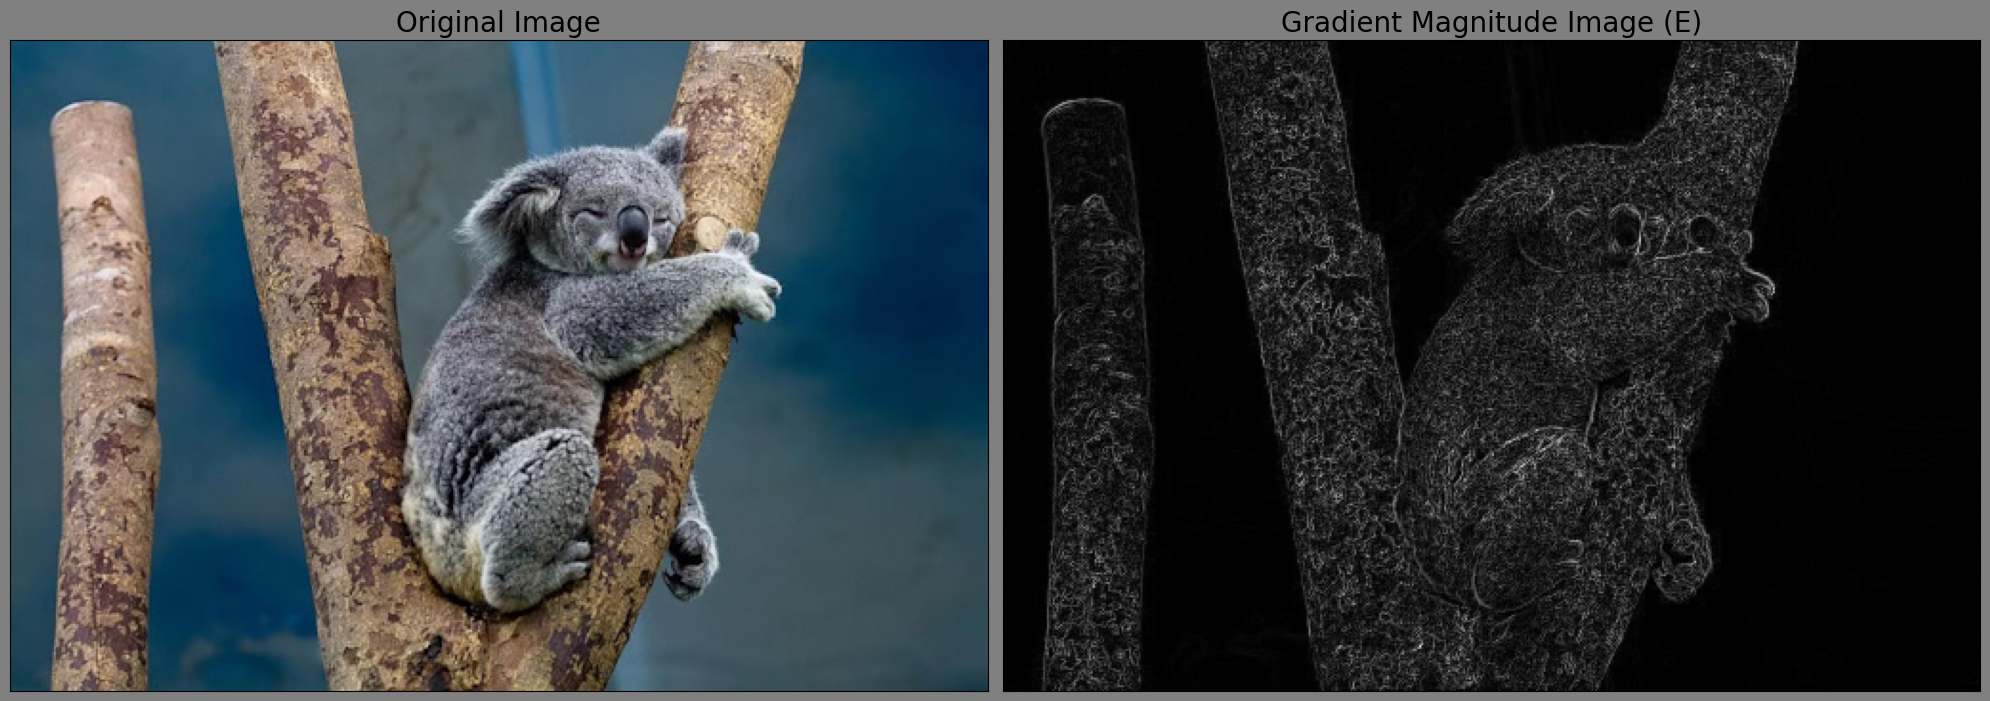

In [8]:
# display matrices

ax, font_size = init_plt_grid(ncols=2)

ax[0].set_title('Original Image', **font_size)
ax[1].set_title('Gradient Magnitude Image (E)', **font_size)

assert gs_img.rgb is not None, "No RGB image"
assert gs_img.E is not None, "No energy matrix"

ax[0].imshow(gs_img.rgb)
ax[1].imshow(gs_img.E, cmap='gray')

for sp in ax.reshape(-1):
    sp.set_xticks([])
    sp.set_yticks([])

plt.tight_layout()

In [9]:
# remove seams (modify as you wish, but keep for submission)
%time gs_img.seams_removal_vertical(150)
%time gs_img.seams_removal_horizontal(50)

TODO: Implement SeamImage.seams_removal_horizontal
CPU times: total: 0 ns
Wall time: 0 ns
TODO: Implement SeamImage.seams_removal_horizontal
CPU times: total: 0 ns
Wall time: 0 ns


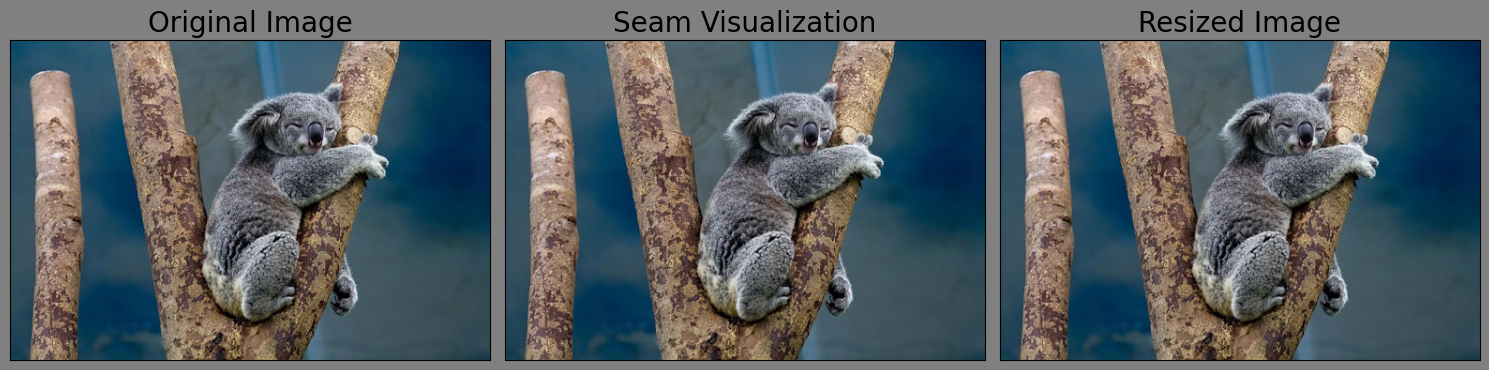

In [10]:
plot_grid(gs_img)

Now, the greedy versio of the algorithm works, but it makes a couple of mistakes. For example, it cuts up the tree and the koala's back.


The main problem is that it makes a decision on a row-by-row basis, so it may make an optimal choice early on that will create an overall less optimal seam.

Therefore, the greedy algorithm does not consider the *overall* cost of a seam. It only considers the cost *per row*.

To improve this, the algorithm needs to minimize the cost of the *entire* seam.

The trivial approach is to calculate all possible seams, and choose the one with the lowest cost.

While this is less efficient, it can be optimized using a trick you have already learned - dynamic programming.

### TODO: Implement the DPSeamImage class (20 points)

DPSeamImage implements seam carving using dynamic programming.
This also stores meta data such as: grayscale version, gradient magnitude map, boolean masks indicating if a seam is removed or not, resized versions etc.
Same as above, this class also should support horizontal seam carving.

Guidelines:
* Implement the Energy matrix $M$ as guided
* `VerticalSeamImage.seams_removal_horizontal` and `VerticalSeamImage.seams_removal_horizontal` are wrappers to `VerticalSeamImage.seams_removal` which is the main method where all the magic happens. This process includes:
    * Gradient magnitude of each pixel of self.gs (= self.E)
    * Calculating pixel energy as taught, but with certain terms omitted (= self.M)
    * iterate for *num_remove* times d:
        * Calculate $E$ and $M$ (self.E, self.M respectively)
        * Calculate the dynamic programming matrix
        * Find the minimal seam
        * Remove and update the seam from all metadata matrices
* You are expected to report similar runtime as our implementations
    * Note that this *will* be slower than the greedy implementation
        
*Important: In order to get reasonable runtime, use the Numba decorator by uncommenting `@jit(nopython=True)` above `DPSeamImage.calc_bt_mat`*

In [11]:
# Create an instance of the DP algorithm
vs_img = DPSeamImage(img_path=img_path, vis_seams=True)

TODO: Implement DPSeamImage.calc_M


AssertionError: No cost matrix

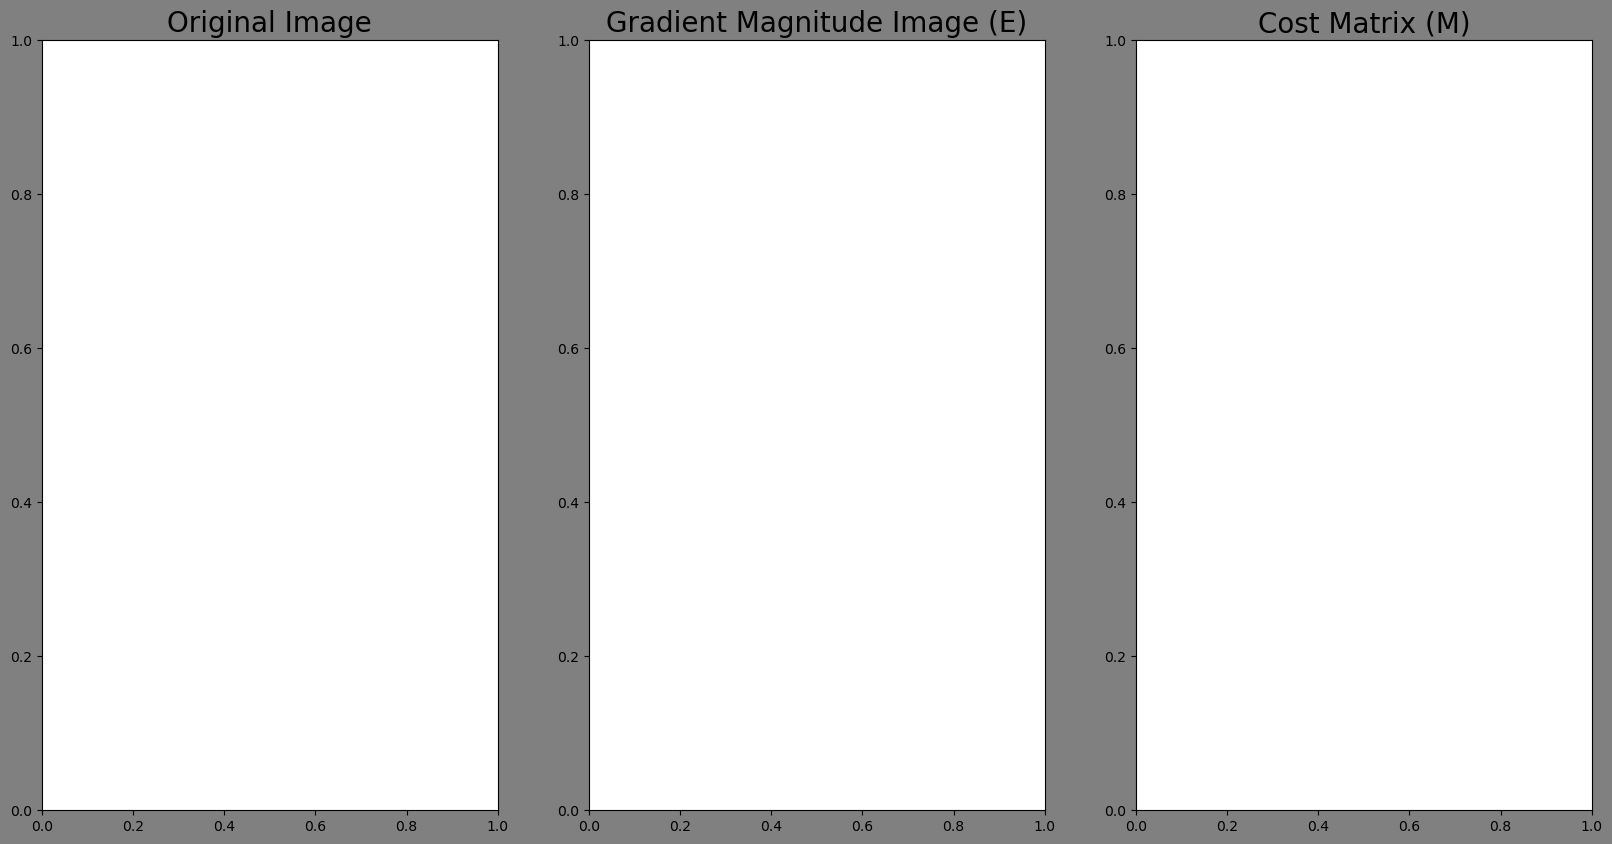

In [12]:
# display matrices

ax, font_size = init_plt_grid(ncols=3)

ax[0].set_title('Original Image', **font_size)
ax[1].set_title('Gradient Magnitude Image (E)', **font_size)
ax[2].set_title('Cost Matrix (M)', **font_size)

assert vs_img.rgb is not None, "No RGB image"
assert vs_img.E is not None, "No energy matrix"
assert vs_img.M is not None, "No cost matrix"

ax[0].imshow(vs_img.rgb)
ax[1].imshow(vs_img.E, cmap='gray')
ax[2].imshow(vs_img.M)

for sp in ax.reshape(-1):
    sp.set_xticks([])
    sp.set_yticks([])

plt.tight_layout()

In [ ]:
# remove seams (modify as you wish, but keep for submission)
%time vs_img.seams_removal_vertical(150)
%time vs_img.seams_removal_horizontal(50)

In [ ]:
plot_grid(vs_img)

Notice how the koala is preserved unlike before. Much better!

#### Ask yourself

Why are the seams different between the algorithms? What image artifact can consistently cause a greedy algorithm to consistently choose less optimal seams?

### Bonus: Time Complexity (3 point)

What is the time complexity of finding a seam in the greedy algorithm vs the dynamic programming algorithm?

Let `w` and `h` be the width and height of the image, respectively.

```
TODO (Bonus)

Greedy - O(?)
DP - O(?)
```

Do your runtimes match the complexities? If not, can you think of a reason why?

### Bonus: Seam Carving for Image Enlarging (7 points)
As discussed in the unit, a seam's "importance" can be also used to enlarge images bysimply duplicating the least important seam every time.

Implement `SeamImage.seams_addition`:
* You may use wrapper functions for vertical/horizontal (same as in the removal process)
* Paint the added seams in green
* To get full bonus credit, use the example image and plot the visualization after: i) adding 50 vertical seams. ii) adding 50 horizontal seams
* For this part you can add the necessary cells bellow (for plotting)

In [ ]:
vs_img.reinit()
try:
    vs_img.seams_addition_horizontal(50)
except NotImplementedError as e:
    print(e)

## Method Comparison and Recaling (10 points)

In this final section you will be comparing the two methods with bilinear interpolation (a rescaling algorithm, implemented for you).

In [ ]:
from utils import bilinear

scale_factors = [[.6, 1.], [1., .6]] # -> scale_factors[i,0] for height and scale_factors[i,1] for width

In [ ]:
img_path = 'images/palawan2.jpg'

img = read_image(img_path)
print(img.shape)
show_image(img.astype('int'));

In [ ]:
aspect_ratio = img.shape[1] / img.shape[0] # -> claculate the image AR
print('Aspect ratio:', aspect_ratio)

##### TODO: Implement `scale_to_shape` and `resize_seam_carving` (5 + 5 points)
* `scale_to_shape` takes an image shape (y,x) and $f_y,f_x$ scale factors and returns the new image shape.
* `resize_seam_carving` takes a SeamImage instance along with the new shape and applies the resize.

In [ ]:
data = {}
vs_img = DPSeamImage(img_path)

for s in scale_factors:
    orig_shape = np.asarray(img.shape[:-1])
    new_shape = scale_to_shape(orig_shape, s)
    bi_resized_rgb = bilinear(img, new_shape)
    vs_resized_rgb = resize_seam_carving(vs_img, (orig_shape, new_shape))
    data[str(s)] = (bi_resized_rgb, vs_resized_rgb)

In [ ]:
# Results comparison

ax, font_size = init_plt_grid(3, 2, figsize=(20,15))


ax[0,0].set_title(f'Scale Factor {scale_factors[0]}', **font_size)
ax[0,1].set_title(f'Scale Factor {scale_factors[1]}', **font_size)

ax[0,0].set_ylabel('Original', **font_size)
ax[1,0].set_ylabel('Bilinear Interp.', **font_size)
ax[2,0].set_ylabel('SC', **font_size)


ax[0,0].imshow(img.astype('uint'))
ax[1,0].imshow(data[str(scale_factors[0])][0])
ax[2,0].imshow(data[str(scale_factors[0])][1])

ax[0,1].imshow(img.astype('uint'))
ax[1,1].imshow(data[str(scale_factors[1])][0])
ax[2,1].imshow(data[str(scale_factors[1])][1])


for sp in ax.reshape(-1):
    sp.set_xticks([])
    sp.set_yticks([])

plt.tight_layout()


### Discussion and Conclusion

##### Discussion
* DP matrices: pay attention to the DP matrices you calculated. They should give an intuition of the correctness of your implemetions.
* Seam Visualization: There are two noticible phenomenons when looking at them: i) Some seams might be corrupted (side to side). Why is it? which type of seams is it likely to occur? ii) The chosen seams tend to avoid "important" content.
* Greedy vs DP: greedy is much faster, as it does not need to check the entire image for every seam. It makes a decision row-by-row, as opposed to DP which has to create a matrix covering the whole image. However, it comes at a trade-off of rescaling quality, as greedy may create less-optimal seams when it encounters a local minimum. The DP algorithm enables to take the less optimal paths early on, only if it makes an overall better seam.
* Rescaling and resizing: It can be seen that Resizing images preserves geometry of objects, which emphasizes the adavantages of the content-awareness of Seam Carving. On the other hand, rescaling modifies existing image pixels and thus might affect its content.

##### Conclusion
* We have implemented two applications of the Seam Carving algorithms
* We have compared Seam Carving to some content-aware methods and discussed their pros/cons
* This implementation can be extended into some possible directions:
    * Removing objects while keeping the same image size
    * Adding objects into images
    
**Good Luck!**
